# License Plate Recognition

In [13]:
import os
import random
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [14]:
import cv2
import ffmpeg
# from fastai.imports import *
# from fastai.torch_imports import *
# from fastai.transforms import *
# from fastai.conv_learner import *
# from fastai.model import *
# from fastai.dataset import *
# from fastai.sgdr import *
# from fastai.plots import *
# from numpy import random

## Generate training data

In [15]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [16]:
PATH = 'data/lpr/'
#!wget -O data/lpr/sample.jpg --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" https://www.tv2nord.dk/files/styles/16_9_large_2x/public/images/crop/2020/02/26/1582735544_img_1231_0.jpg
sample = f'{PATH}sample.jpg'
image = Image.open(sample)

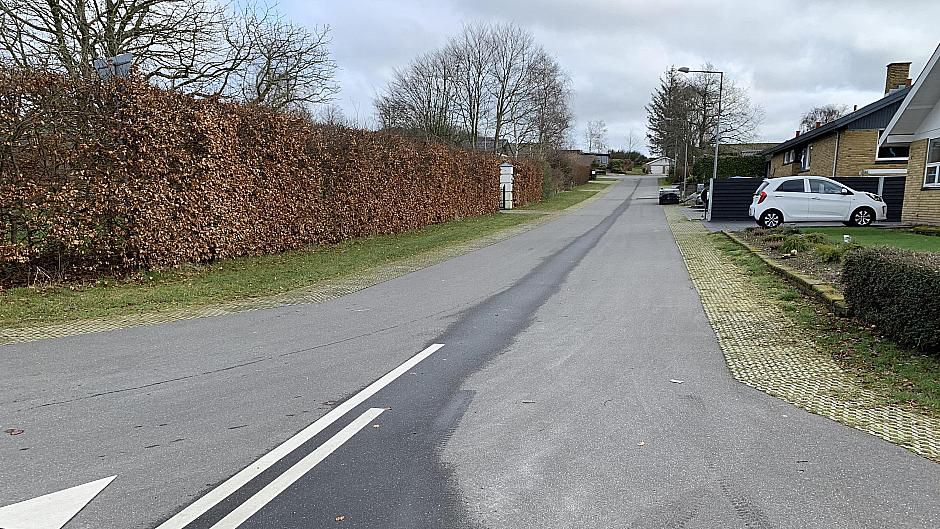

In [17]:
image

In [18]:
image.size

(940, 529)

### Generate license plate

In [19]:
def license_plate(image: Image, license: str, width = 40):
    w = width
    h = (int)(w / 4)
    red_width = (int)(w / 100)
    font_size = (int)(w / 5)
    
    #font = ImageFont.truetype('/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-C.ttf', font_size)
    #font = ImageFont.truetype('/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf', font_size)
    #font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSansBold.ttf', font_size)
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', font_size)
    
    size = (w, h)
    plate = Image.new('RGB', size, "red")
    
    draw = ImageDraw.Draw(plate)
    draw.rectangle(((red_width, red_width),(w-red_width-1, h-red_width-1)), fill="white")
    (tw, th) = font.getsize(license)
    text_position = ((w-tw)/2, (h-th)/2-1)
    #draw.rectangle(text_position + (text_position[0]+tw,text_position[1]+th), fill="blue")
    draw.text(text_position, license, font=font, fill="black")
    #draw.line([(9,9), (9+tw,9+th)], width=1)
    
    box = (random.randint(0, image.size[0] - w), random.randint(0, image.size[1] - h))
    bbox = (box[0], box[1], box[0]+w, box[1]+h)
    image.paste(plate, box=box)
    
    
    return bbox, image

In [20]:
bbox, sample = license_plate(image, 'UM 12 345', 50)
bbox

(72, 17, 122, 29)

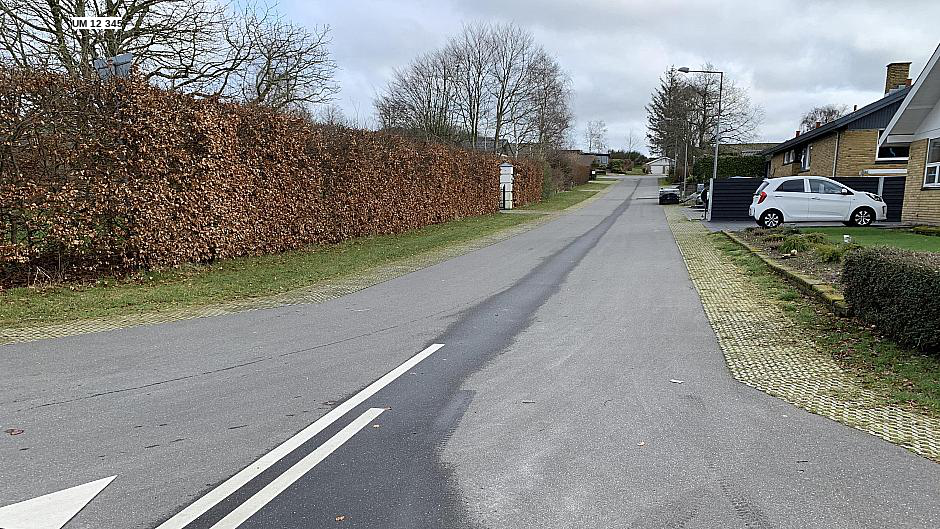

In [21]:
sample

In [22]:
def show_bbox(image: Image, bbox) -> ImageDraw:
    color1 = "yellow"
    color2 = "black"
    width = 2
    draw = ImageDraw.Draw(image)
    # draw.line(((10,20,60,100)), fill="red")
    draw.line((bbox[0], bbox[1], bbox[2], bbox[1]), fill=color1, width=width)
    draw.line((bbox[2], bbox[1], bbox[2], bbox[3]), fill=color1, width=width)
    draw.line((bbox[2], bbox[3], bbox[0], bbox[3]), fill=color1, width=width)
    draw.line((bbox[0], bbox[3], bbox[0], bbox[1]), fill=color1, width=width)

    draw.line((bbox[0]-width, bbox[1]-width, bbox[2]+width, bbox[1]-width), fill=color2, width=width)
    draw.line((bbox[2]+width, bbox[1]-width, bbox[2]+width, bbox[3]+width), fill=color2, width=width)
    draw.line((bbox[2] + width, bbox[3] + width, bbox[0]-width, bbox[3]+width), fill=color2, width=width)
    draw.line((bbox[0]- width, bbox[3]+width, bbox[0]-width, bbox[1]-width), fill=color2, width=width)

    return draw


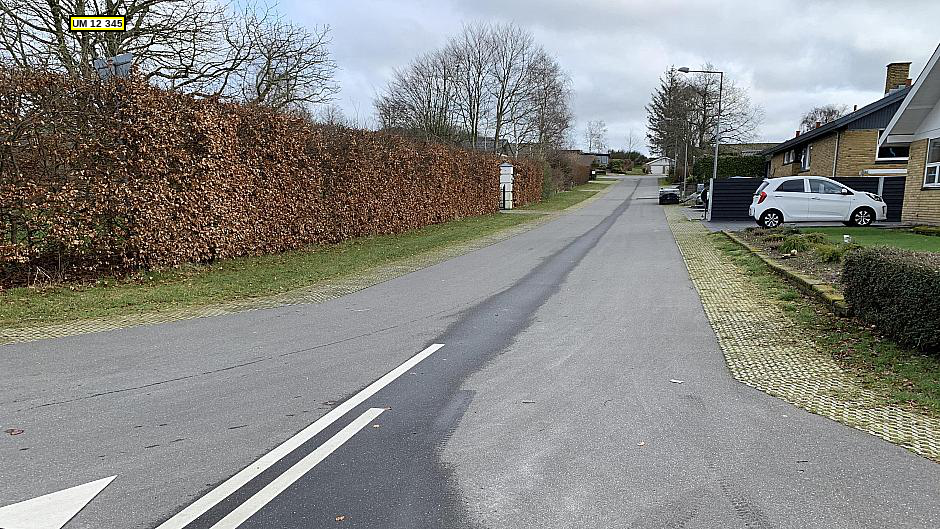

In [23]:
# from IPython.display import Image
#imshow(show_bbox(sample, bbox))
# imshow(show_bbox(sample, bbox))
show_bbox(sample, bbox)
sample

In [24]:
path_frames = f'{PATH}frames/'
try:
    if not os.path.exists(path_frames):
        os.makedirs(path_frames)
except OSError:
    print("Cannot create dir for frames")

In [25]:
def check_rotation(path_video_file):
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)

    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotateCode = None
    if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
        rotateCode = cv2.ROTATE_90_CLOCKWISE
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
        rotateCode = cv2.ROTATE_180
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
        rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE

    return rotateCode

In [26]:
def correct_rotation(frame, rotateCode):
    return cv2.rotate(frame, rotateCode)

In [27]:
def split_video_in_frames(video):
    capture = cv2.VideoCapture(video)
    rotateCode = check_rotation(video)
    ret = True
    currentFrame = 0
    while(ret and currentFrame < 1000):
        ret, frame = capture.read()
        # frame = cv2.flip(frame, 0)
        if rotateCode is not None:
            frame = correct_rotation(frame, rotateCode)
        if (ret):
            name = path_frames + str(currentFrame) + '.jpg'
            #print ('Creating ' + name)
            cv2.imwrite(name, frame)
            currentFrame += 1
    capture.release()
    cv2.destroyAllWindows()
    return currentFrame

In [28]:
# Flip video vertically
#!ffmpeg -i video.mp4 -vf "vflip" out.mp4

In [29]:
video = f"{PATH}in.mp4"
frames_created = split_video_in_frames(video)
f'{frames_created} frames created.'

'1000 frames created.'

## Generate license plates

In [30]:
path_train = f'{PATH}train/'
try:
    if not os.path.exists(path_train):
        os.makedirs(path_train)
except OSError:
    print("Cannot create dir for training images")

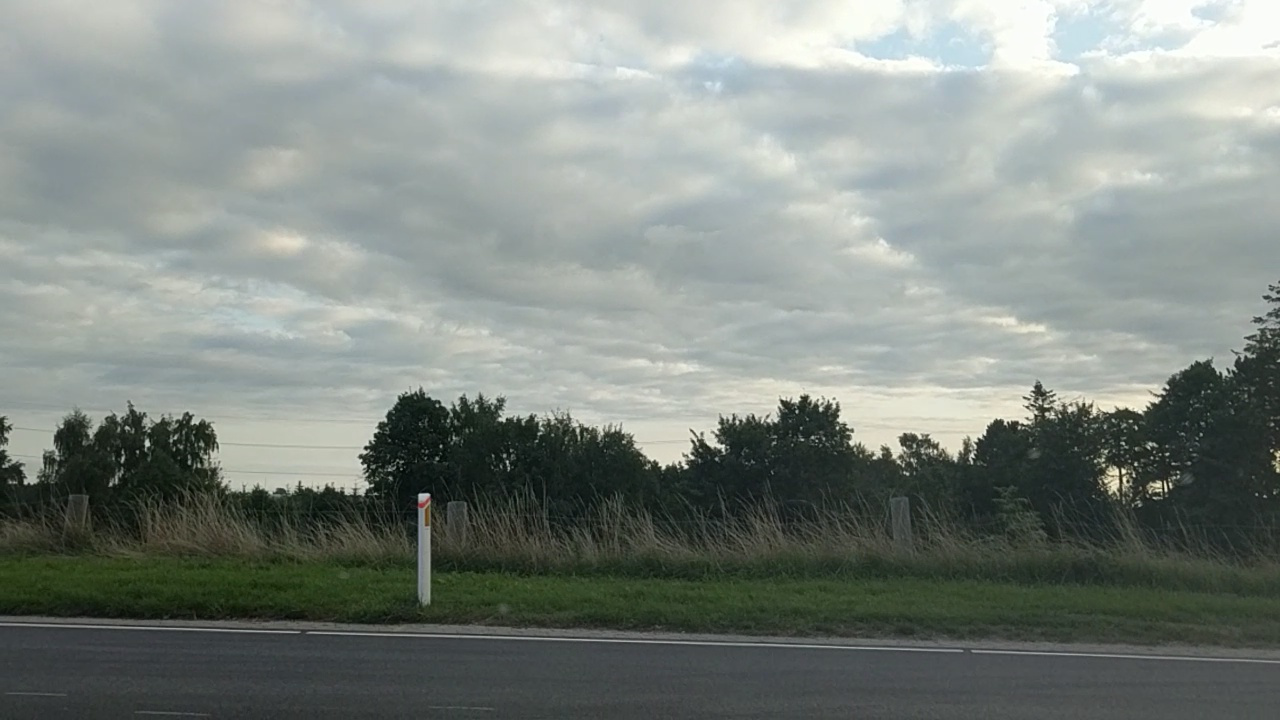

In [31]:
max = !ls data/lpr/frames | wc -l
max = int(max[0]) - 1
def random_image():
    filename = path_frames + str(random.randint(0, max)) + '.jpg'
    return Image.open(filename)
random_image()

In [32]:
def random_letter() -> str:
    return random.choice("ABCDEFGHIJKLMNOPQRSTUXYZ")

def random_number() -> str:
    return str(random.randint(10000, 99999))

def random_license() -> str:
    return random_letter() + random_letter() + " " + random_number()

random_license()

'JO 83554'

In [33]:
def create_train_images(n):
    images = []
    for i in range(0, n):
        license = random_license()
        file = path_train + license + ".jpg"
        bbox, image = license_plate(random_image(), license, width=random.randint(30, 60))
        image.save(file)
        images.append((bbox, file))
    return images
                            

In [34]:
train = create_train_images(5)
train

[((985, 453, 1039, 466), 'data/lpr/train/CY 83200.jpg'),
 ((972, 78, 1029, 92), 'data/lpr/train/FY 35918.jpg'),
 ((255, 19, 312, 33), 'data/lpr/train/TO 21720.jpg'),
 ((381, 451, 438, 465), 'data/lpr/train/NZ 91181.jpg'),
 ((805, 9, 839, 17), 'data/lpr/train/LI 67242.jpg')]

In [35]:
train[0][0]

(985, 453, 1039, 466)

In [2]:
Image.open(train[0][1])

NameError: name 'Image' is not defined

In [1]:
image = Image.open(train[0][1])
image = show_bbox(image, train[0][0])
image

NameError: name 'Image' is not defined